In [1]:
import numpy as np
from scipy import stats
from scipy import optimize
import csv
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
# How to use this program: 

# use meterological data from: http://www.ndbc.noaa.gov/

# file name should be in format NNNNNhYYYY.txt 
# NNNNN is the station ID.
# YYYY is the year.
# This is the default if you download from the NOAA website.
# add your files to the same folder as this program to ensure they load. 

# on Mac/Linux: 
# open terminal
# run the following line to download your files: 
# wget http://www.ndbc.noaa.gov/data/historical/stdmet/45001h{1982..2016}.txt.gz -P /Users/Elise/Documents/CEE514/final_project
# change 45001 to the number of the station you want to download

# Station Numbers:
# 45001 - MID SUPERIOR   - 1979-2016
# 45002 - NORTH MICHIGAN - 1979-2016
# 45003 - NORTH HURON    - 1980-2016
# 45004 - EAST SUPERIOR  - 1980-2016
# 45005 - WEST ERIE      - 1980-2016
# 45006 - WEST SUPERIOR  - 1981-2016
# 45007 - SOUTH MICHIGAN - 1981-2016
# 45008 - SOUTH HURON    - 1981-2016
# 45012 - EAST ONTARIO   - 2002-2016

# input desired monitors below...

In [3]:
# BEGIN USER INPUT

stationIDList = ["45006", "45001", "45004", "45002", "45007","45003","45008","45005"]
stationNameList = ["WEST SUPERIOR", "MID SUPERIOR", "EAST SUPERIOR", "NORTH MICHIGAN",
                   "SOUTH MICHIGAN","NORTH HURON", "SOUTH HURON", "WEST ERIE"]
                   
startYear = 1981
endYear = 2016

bins = np.array([0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 
                 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 
                 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0]) # units in m

threshold = 3.0 # minimum wave value to perform analysis on.

# END USER INPUT

In [4]:
# have it read in all years
def read_in_data(filePrefix,fileSuffix,startYear,endYear):
    # based on example in https://stackoverflow.com/questions/16503560/read-specific-columns-from-a-csv-file-with-csv-module
    #data = defaultdict(list) # each value in each column is appended to a list
    waveheight = np.array([])
    
    for year in np.arange(startYear,endYear+1):
        with open(filePrefix + str(year) + fileSuffix) as f:
            reader = csv.reader(f, delimiter = " ", skipinitialspace=True)
            header  = reader.next() # store the header and move to the next line
            wvhtInd = header.index('WVHT') # get the index of the WVHT column from the header
            if year > 2006: # Format changes after 2006 to include units. Skip the extra header.
                reader.next() 
            #reader = csv.DictReader(f, delimiter = " ", skipinitialspace=True) # read rows into a dictionary format
            for row in reader: # read a row as {column1: value1, column2: value2,...}
                v = row[wvhtInd]
                #for (k,v) in row.items(): # go over each column name and value 
                if np.isclose(float(v), 99.00): # if value=99.00
                    waveheight = np.append(waveheight,np.nan)
                    #data[k].append(np.nan) # append missing value
                else:
                    waveheight = np.append(waveheight,np.float(v))
                    #data[k].append(float(v)) # append the value into the appropriate list
                                              # based on column name k
    
    #print "list of key names in data"
    #for key, value in data.iteritems() :
    #    print key
        
    return waveheight

# find probabilities
def find_prob(data,bins,threshold):

    # bin your waveheight data
    freq = np.zeros(np.size(bins))
    prob = np.zeros(np.size(bins))
    q = np.zeros(np.size(bins))
    inds = np.digitize(wvhtFiltered,bins,right=False) # assigns index to each bin. 
                                                        # right side closed
                                                        # (i.e. values>highest value not counted)
    # calculate frequency of each bin
    freq = np.array([1.0*np.sum(inds==n) for n in np.arange(np.size(bins))])

    # calculate probability for each bin
    prob = freq/np.sum(freq)

    # calculate probability of exceedence
    q = np.array([np.sum(prob[i:]) for i in np.arange(np.size(bins))])

    # calculate the cumulative freqeuncy density p = 1-q
    p = np.array([1.0 - item for item in q])

    threshold = 2.0 # we won't look at wave heights lower than 2.0m

    pThresh = p[bins>threshold]
    heightThresh = bins[bins>threshold]
    
    #print "Max wvht is %f." % np.nanmax(wvht)
    
    return freq, pThresh, heightThresh

# log normal
def log_normal_regress(pArray,heights):
    # calculate z and the log of height
    logHeight = np.array([np.log(1.0*h) for h in heights])
    z = np.array([stats.norm.ppf(1.0*p) for p in pArray])
    
    # remove infinite values
    logHeight = logHeight[np.isfinite(z)]
    z = z[np.isfinite(z)]
    
    # find line of best fit and r value
    slope, intercept, rValue, pValue, stdErr = stats.linregress(logHeight,z)
    
    return slope, intercept, rValue**2
     
    
# gumbel
def gumbel_regress(pArray,heights):
    heights = np.array(heights)
    G = np.array([-np.log(np.log(1.0/(1.0*p))) for p in pArray])
    
    # find line of best fit and r value
    slope, intercept, rValue, pValue, stdErr = stats.linregress(heights,G)
    
    return slope, intercept, rValue**2


# weibull_fit 
# returns r value of regression for use minimizing alpha
def weibull_fit(alpha, pArray, heights):
    heights = np.array(heightsWeibull)
    weibull = np.array([np.log(1./(1.-1.0*pVal))**(1./alpha) for pVal in pArrayWeibull])
    slope, intercept, rValue, pValue, stdErr = stats.linregress(heights,weibull)
    return 1.0-rValue

# reduced variate weibull
def weibull_regress(pArray,heights,alpha):
    heights = np.array(heights)
    weibull = np.array([np.log(1./(1.-1.0*p))**(1./alpha) for p in pArray])
    
    # find line of best fit and r value
    slope, intercept, rValue, pValue, stdErr = stats.linregress(heights,weibull)
    
    return slope, intercept, rValue**2

In [5]:
hExtremeList = [] # holds extreme wave height values for each station

for ID in stationIDList:
    name = stationNameList[stationIDList.index(ID)]
    print "Processing "+name
    
    filePrefix = ID + "h" # filename before the year
    fileSuffix = ".txt" # filename after the year

    # Read in data and sort it into bins
    data = read_in_data(filePrefix,fileSuffix,startYear,endYear)
    wvht = np.array(data) # waveheight
    wvhtFiltered = wvht[~np.isnan(wvht)] # remove nans from wvht array
    freq, pThresh, heightThresh = find_prob(wvhtFiltered,bins,threshold)
    
    # Log-Normal
    logHeights = np.log10(heightThresh[pThresh!=0.0]) # for use plotting later
    # do a regression for the Log-Normal distribution
    logNormA, logNormB, logNormR2 = log_normal_regress(pThresh[pThresh!=0.0],
                                                   heightThresh[pThresh!=0.0])
    
    # Gumbel
    # filter wave heights appropriately
    heightsGumbel = heightThresh[np.logical_and(pThresh!=0.0,pThresh!=1.0)]
    pArrayGumbel = pThresh[np.logical_and(pThresh!=0.0,pThresh!=1.0)]
    # do a regression for the Gumbel distributions
    gumbelA, gumbelB, gumbelR2 = gumbel_regress(pArrayGumbel,heightsGumbel)
    
    # Weibull
    heightsWeibull = heightThresh[pThresh!=1.0]
    pArrayWeibull = pThresh[pThresh!=1.0]
    # optimize alpha
    alpha = optimize.minimize_scalar(weibull_fit, args=(pArrayWeibull,heightsWeibull), 
                                     bounds=(0.01,10.), method='bounded')
    alpha = alpha['x']
    # do a regression for the Weibull curve
    weibullA, weibullB, weibullR2 = weibull_regress(pArrayWeibull, heightsWeibull, alpha)
  
    # Calculate probability of an N year wave occuring in our dataset
    lmbda = np.sum(freq[bins>threshold])/(1.0*endYear-1.0*startYear+1.0)

    p10 = 1. - 1/(lmbda * 10.)
    p50 = 1. - 1/(lmbda * 50.)
    p100 = 1. - 1/(lmbda * 100.)
    p200 = 1. - 1/(lmbda * 100.)

    pExtreme = np.array([p10,p50,p100,p200])

    # Find which method gives the highest r^2 
        # use that method to find 10- 50- 100- and 200-year waves
    if (weibullR2 >= np.max([gumbelR2, logNormR2])): # Weibull
        hExtreme = np.array([(np.log(1./(1.-1.0*p))**(1./alpha)-weibullB)/weibullA 
                             for p in pExtreme])
    elif (gumbelR2 >= np.max([weibullR2, logNormR2])): # Gumbel
        hExtreme = np.array([(-np.log(np.log(1.0/(1.0*p)))-gumbelB)/gumbelA 
                             for p in pExtreme])
    elif (logNormR2 >= np.max([weibullR2,gumbelR2])): # Log Normal
        hExtreme = np.array([np.exp((stats.norm.ppf(1.0*p)-logNormB)/logNormA) 
                             for p in pExtreme])

    hExtremeList.append(hExtreme)
    
    
#     print "10,%2.2f" % hExtreme[0]
#     print "50,%2.2f" % hExtreme[1]
#     print "100,%2.2f" % hExtreme[2]

hExtremeList = zip(*hExtremeList) # sort by Tr value rather than monitor

Processing WEST SUPERIOR
Processing MID SUPERIOR
Processing EAST SUPERIOR
Processing NORTH MICHIGAN
Processing SOUTH MICHIGAN
Processing NORTH HURON
Processing SOUTH HURON
Processing WEST ERIE


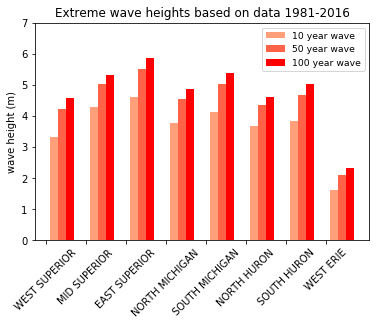

In [7]:
multiple_bars = plt.figure()
ind = np.arange(np.size(stationIDList))

h10 = hExtremeList[0]
h50 = hExtremeList[1]
h100 = hExtremeList[2]

width = 0.2

# plot the extreme wave heights
# inspiration https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars
fig = plt.figure(num=48)
ax = fig.add_subplot(111)
ax.bar(ind, h10,width=0.2,color='lightsalmon',align='center',label="10 year wave")
ax.bar(ind+width, h50,width=0.2,color='tomato',align='center',label="50 year wave")
ax.bar(ind+width*2., h100,width=0.2,color='r',align='center',label="100 year wave")
ax.xaxis_date()

ax.set_ylabel('wave height (m)')
ax.set_xticks(ind-width)
ax.set_xticklabels( stationNameList )
plt.xticks(rotation=45)
plt.title("Extreme wave heights based on data %s-%s" % (startYear, endYear))
plt.ylim([0.,7.])
plt.legend(loc=0,prop={'size': 9.3})

plt.show()